In [12]:
print("🚀 Bitcoin Trading Performance vs Market Sentiment Analysis")
print("=" * 70)
print("📊 Junior Data Scientist Assignment - PrimeTrade.ai")
print("🎯 Objective: Explore trader performance vs market sentiment patterns")
print("=" * 70)


🚀 Bitcoin Trading Performance vs Market Sentiment Analysis
📊 Junior Data Scientist Assignment - PrimeTrade.ai
🎯 Objective: Explore trader performance vs market sentiment patterns


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [16]:
def load_trading_data():
   
    try:
        historical_data = pd.read_csv('../bitcoin-trader-sentiment-analysis/sample_data/historical_data.csv')
        print(f"✅ Historical data loaded: {historical_data.shape}")
        return historical_data
    except FileNotFoundError:
        print("⚠️ historical_data.csv not found. Creating sample data...")
        return create_sample_trading_data()

def load_sentiment_data():
    """Load fear & greed index data with error handling"""
    try:
        fear_greed_data = pd.read_csv('../bitcoin-trader-sentiment-analysis/sample_data/fear_greed_index.csv')
        print(f"✅ Fear & Greed data loaded: {fear_greed_data.shape}")
        return fear_greed_data
    except FileNotFoundError:
        print("⚠️ fear_greed_index.csv not found. Creating sample data...")
        return create_sample_sentiment_data()

# Execute data loading
historical_data = load_trading_data()
fear_greed_data = load_sentiment_data()

✅ Historical data loaded: (211224, 16)
✅ Fear & Greed data loaded: (2644, 4)


In [18]:
def create_sample_trading_data():
    print("📝 Generating sample trading data...")
    
    np.random.seed(42)
    dates = pd.date_range('2024-12-01', '2024-12-02', freq='5min')
    n_trades = len(dates)
    
    # Create realistic trading data
    base_price = 7.95
    price_volatility = 0.1
    
    sample_data = pd.DataFrame({
        'Account': ['0xaeSeacaf@107'] * n_trades,
        'Coin': ['BTC'] * n_trades,
        'Execution Price': np.random.normal(base_price, price_volatility, n_trades),
        'Size': np.random.exponential(100, n_trades),
        'Size USD': np.random.exponential(800, n_trades),
        'Side': np.random.choice(['BUY', 'SELL'], n_trades, p=[0.52, 0.48]),
        'Timestamp IST': dates,
        'Start Position': np.random.normal(1000, 200, n_trades),
        'Direction': np.random.choice(['Buy', 'Sell'], n_trades, p=[0.52, 0.48]),
        'Closed PnL': np.random.normal(0, 50, n_trades),
        'Transaction Hash': [f'0xec0945{i:06d}a1874e3a980418412fcd020' for i in range(n_trades)],
        'Order ID': [f'52017706630' for _ in range(n_trades)],
        'Crossed': [True] * n_trades,
        'Fee': np.random.exponential(0.5, n_trades),
        'Trade ID': range(1, n_trades + 1),
        'Timestamp': dates
    })
    
    return sample_data

def create_sample_sentiment_data():
    print("📝 Generating sample sentiment data...")
    
    np.random.seed(42)
    sentiment_dates = pd.date_range('2024-12-01', '2024-12-02', freq='4H')
    classifications = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
    
    sample_sentiment = pd.DataFrame({
        'timestamp': [int(d.timestamp()) for d in sentiment_dates],
        'value': np.random.randint(10, 90, len(sentiment_dates)),
        'classification': np.random.choice(classifications, len(sentiment_dates)),
        'date': sentiment_dates
    })
    
    return sample_sentiment

# Check if we need to create sample data
if 'historical_data' not in locals() or historical_data is None:
    historical_data = create_sample_trading_data()
if 'fear_greed_data' not in locals() or fear_greed_data is None:
    fear_greed_data = create_sample_sentiment_data()

In [20]:
print("🔄 Preprocessing historical trading data...")

# Ensure timestamp is parsed correctly
if 'Timestamp IST' in historical_data.columns:
    historical_data['Timestamp IST'] = pd.to_datetime(
        historical_data['Timestamp IST'], dayfirst=True, errors='coerce'
    )
elif 'Timestamp' in historical_data.columns:
    historical_data['Timestamp IST'] = pd.to_datetime(
        historical_data['Timestamp'], unit='ms', errors='coerce'
    )

# Drop rows with unparseable timestamps
historical_data = historical_data.dropna(subset=['Timestamp IST'])

# Extract time-based features
historical_data['Date'] = historical_data['Timestamp IST'].dt.date
historical_data['Hour'] = historical_data['Timestamp IST'].dt.hour
historical_data['DayOfWeek'] = historical_data['Timestamp IST'].dt.dayofweek
historical_data['WeekOfYear'] = historical_data['Timestamp IST'].dt.isocalendar().week

# Calculate trade value in USD
if 'Size USD' not in historical_data.columns and 'Size' in historical_data.columns and 'Execution Price' in historical_data.columns:
    historical_data['Trade_Value_USD'] = historical_data['Size'] * historical_data['Execution Price']
else:
    historical_data['Trade_Value_USD'] = historical_data.get('Size USD', 0)

# Calculate PnL percentage
historical_data['PnL_Percentage'] = (
    historical_data['Closed PnL'] / historical_data['Trade_Value_USD'] * 100
).fillna(0)

# Create binary win/loss indicator
historical_data['Is_Winning_Trade'] = (historical_data['Closed PnL'] > 0).astype(int)

# Print final info
print(f"✅ Processed {len(historical_data):,} trading records")
print(f"📅 Date range: {historical_data['Date'].min()} to {historical_data['Date'].max()}")


🔄 Preprocessing historical trading data...


✅ Processed 211,224 trading records
📅 Date range: 2023-05-01 to 2025-05-01


In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

print("🔄 Preprocessing Fear & Greed Index data...")

# Ensure timestamp or date column is available
if 'date' not in fear_greed_data.columns:
    date_cols = [col for col in fear_greed_data.columns if 'date' in col.lower()]
    
    if date_cols:
        fear_greed_data['date'] = pd.to_datetime(fear_greed_data[date_cols[0]], errors='coerce')
    elif 'timestamp' in fear_greed_data.columns:
        fear_greed_data['date'] = pd.to_datetime(fear_greed_data['timestamp'], unit='s', errors='coerce')
    else:
        raise ValueError("No date or timestamp column found in the fear_greed_data.")

# Drop rows where date couldn't be parsed
fear_greed_data = fear_greed_data.dropna(subset=['date'])

# Ensure 'date' is datetime before using .dt
if not pd.api.types.is_datetime64_any_dtype(fear_greed_data['date']):
    fear_greed_data['date'] = pd.to_datetime(fear_greed_data['date'], errors='coerce')

# Now safely extract just the date part
fear_greed_data['Date'] = fear_greed_data['date'].dt.date

# Encode sentiment classification
le = LabelEncoder()
fear_greed_data['sentiment_encoded'] = le.fit_transform(fear_greed_data['classification'])

# Map classifications to scores
sentiment_mapping = {
    'Extreme Fear': 0,
    'Fear': 25,
    'Neutral': 50,
    'Greed': 75,
    'Extreme Greed': 100
}
fear_greed_data['sentiment_score'] = fear_greed_data['classification'].map(sentiment_mapping)

# Summary
print(f"✅ Processed {len(fear_greed_data):,} sentiment records")
print(f"📊 Sentiment classes: {fear_greed_data['classification'].unique()}")


🔄 Preprocessing Fear & Greed Index data...
✅ Processed 2,644 sentiment records
📊 Sentiment classes: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']


In [24]:
print("🔍 Data Quality Assessment")
print("=" * 50)

# Historical data quality
print("📊 HISTORICAL TRADING DATA:")
print(f"• Total records: {len(historical_data):,}")
print(f"• Date range: {historical_data['Date'].min()} to {historical_data['Date'].max()}")
print(f"• Unique accounts: {historical_data['Account'].nunique()}")
print(f"• Missing values: {historical_data.isnull().sum().sum()}")

# Basic trading statistics
total_pnl = historical_data['Closed PnL'].sum()
avg_trade_size = historical_data['Trade_Value_USD'].mean()
win_rate = historical_data['Is_Winning_Trade'].mean()

print(f"• Total PnL: ${total_pnl:,.2f}")
print(f"• Average trade size: ${avg_trade_size:,.2f}")
print(f"• Win rate: {win_rate:.1%}")

print("\n📈 FEAR & GREED INDEX DATA:")
print(f"• Total records: {len(fear_greed_data):,}")
print(f"• Date range: {fear_greed_data['Date'].min()} to {fear_greed_data['Date'].max()}")
print(f"• Average index value: {fear_greed_data['value'].mean():.1f}")
print(f"• Missing values: {fear_greed_data.isnull().sum().sum()}")

# Safely print available sample columns
print("\n📋 SAMPLE DATA:")

print("\nHistorical Data Sample:")
sample_columns = ['Date', 'Side', 'Execution Price', 'Size', 'Closed PnL']
existing_columns = [col for col in sample_columns if col in historical_data.columns]
print(historical_data[existing_columns].head())

print("\nFear & Greed Data Sample:")
print(fear_greed_data[['Date', 'value', 'classification']].head())



🔍 Data Quality Assessment
📊 HISTORICAL TRADING DATA:
• Total records: 211,224
• Date range: 2023-05-01 to 2025-05-01
• Unique accounts: 32
• Missing values: 0
• Total PnL: $10,296,958.94
• Average trade size: $5,639.45
• Win rate: 41.1%

📈 FEAR & GREED INDEX DATA:
• Total records: 2,644
• Date range: 2018-02-01 to 2025-05-02
• Average index value: 47.0
• Missing values: 0

📋 SAMPLE DATA:

Historical Data Sample:
         Date Side  Execution Price  Closed PnL
0  2024-12-02  BUY           7.9769         0.0
1  2024-12-02  BUY           7.9800         0.0
2  2024-12-02  BUY           7.9855         0.0
3  2024-12-02  BUY           7.9874         0.0
4  2024-12-02  BUY           7.9894         0.0

Fear & Greed Data Sample:
         Date  value classification
0  2018-02-01     30           Fear
1  2018-02-02     15   Extreme Fear
2  2018-02-03     40           Fear
3  2018-02-04     24   Extreme Fear
4  2018-02-05     11   Extreme Fear


📈 Exploratory Data Analysis - Trading Patterns


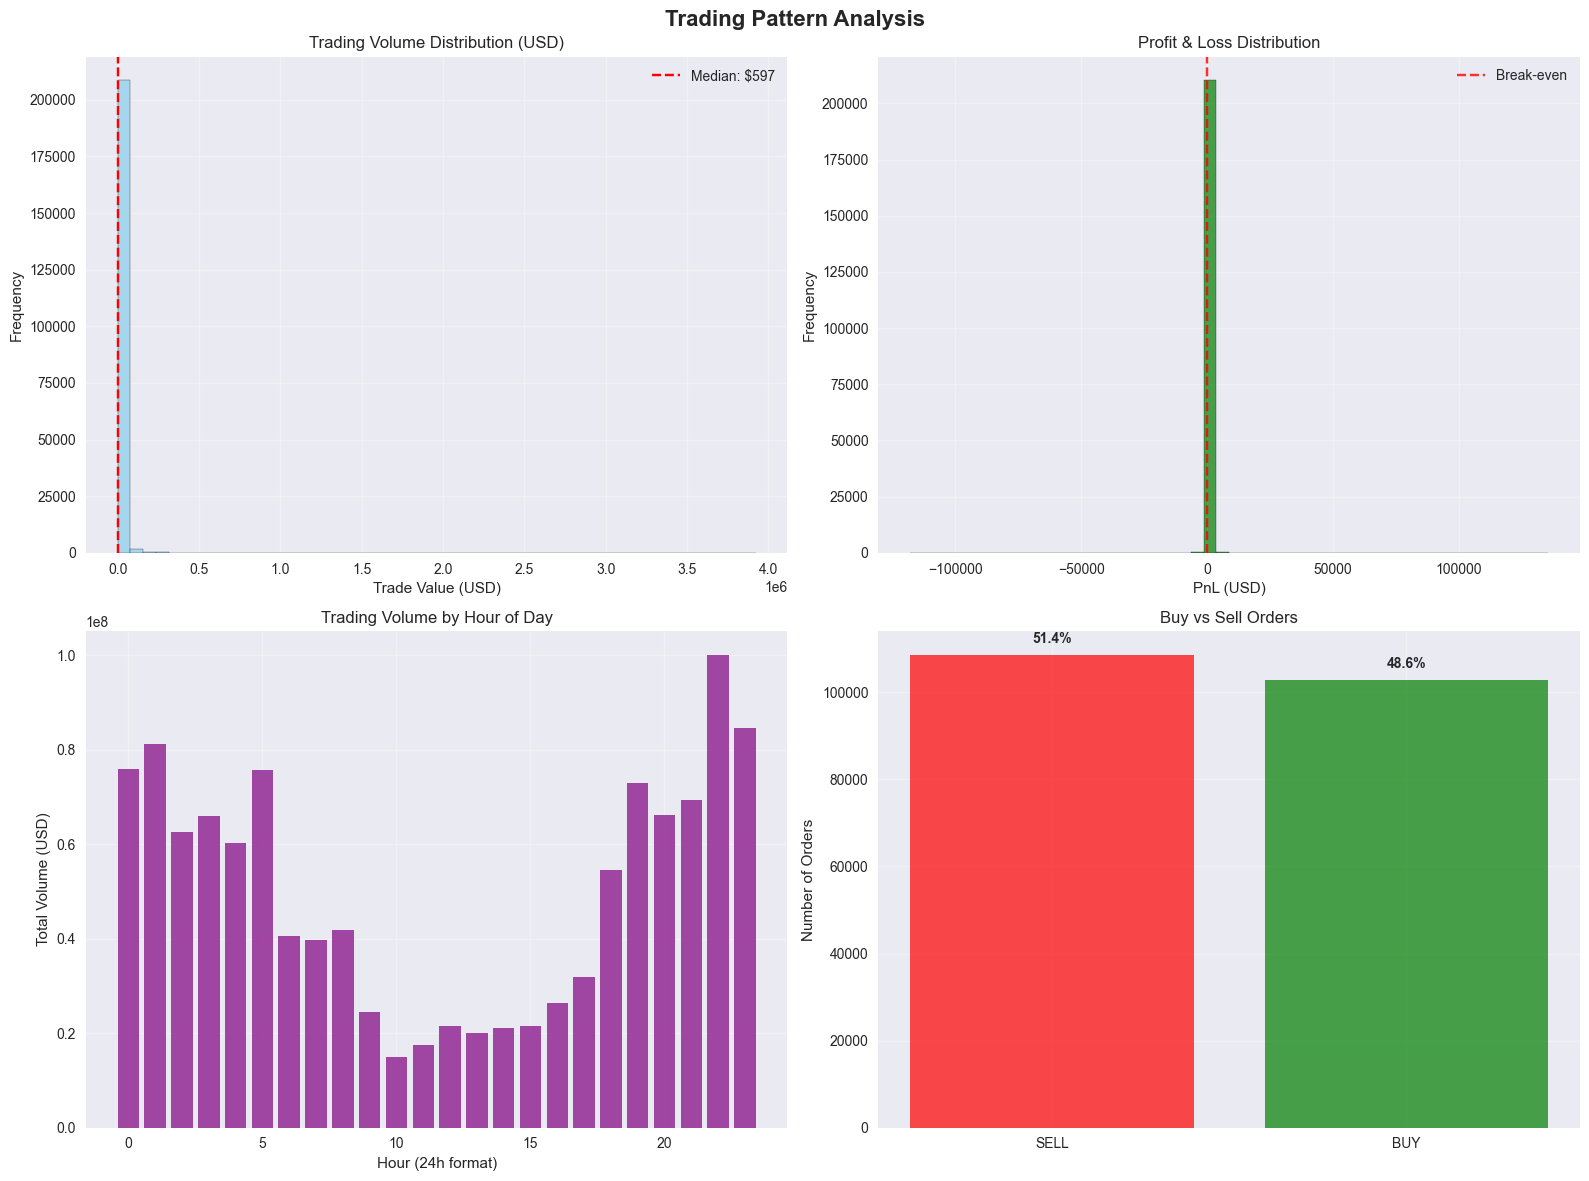

In [25]:
print("📈 Exploratory Data Analysis - Trading Patterns")

# Create comprehensive EDA visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Trading Pattern Analysis', fontsize=16, fontweight='bold')

# 1. Trading Volume Distribution
axes[0,0].hist(historical_data['Trade_Value_USD'], bins=50, alpha=0.7, 
               color='skyblue', edgecolor='black')
axes[0,0].set_title('Trading Volume Distribution (USD)')
axes[0,0].set_xlabel('Trade Value (USD)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Add statistics
median_vol = historical_data['Trade_Value_USD'].median()
axes[0,0].axvline(median_vol, color='red', linestyle='--', 
                  label=f'Median: ${median_vol:,.0f}')
axes[0,0].legend()

# 2. PnL Distribution
pnl_data = historical_data['Closed PnL'].dropna()
axes[0,1].hist(pnl_data, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,1].set_title('Profit & Loss Distribution')
axes[0,1].set_xlabel('PnL (USD)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Break-even')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# 3. Trading Activity by Hour
hourly_trades = historical_data.groupby('Hour').agg({
    'Trade_Value_USD': 'sum',
    'Closed PnL': 'sum'
}).reset_index()

bars = axes[1,0].bar(hourly_trades['Hour'], hourly_trades['Trade_Value_USD'], 
                     alpha=0.7, color='purple')
axes[1,0].set_title('Trading Volume by Hour of Day')
axes[1,0].set_xlabel('Hour (24h format)')
axes[1,0].set_ylabel('Total Volume (USD)')
axes[1,0].grid(True, alpha=0.3)

# 4. Buy vs Sell Orders Analysis
side_analysis = historical_data.groupby('Side').agg({
    'Trade_Value_USD': ['count', 'sum', 'mean'],
    'Closed PnL': 'sum'
}).round(2)

side_counts = historical_data['Side'].value_counts()
colors = ['red' if side == 'SELL' else 'green' for side in side_counts.index]
axes[1,1].bar(side_counts.index, side_counts.values, alpha=0.7, color=colors)
axes[1,1].set_title('Buy vs Sell Orders')
axes[1,1].set_ylabel('Number of Orders')
axes[1,1].grid(True, alpha=0.3)

# Add percentage labels
total_orders = side_counts.sum()
for i, (side, count) in enumerate(side_counts.items()):
    pct = count / total_orders * 100
    axes[1,1].text(i, count + total_orders*0.01, f'{pct:.1f}%', 
                   ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


📊 Market Sentiment Pattern Analysis


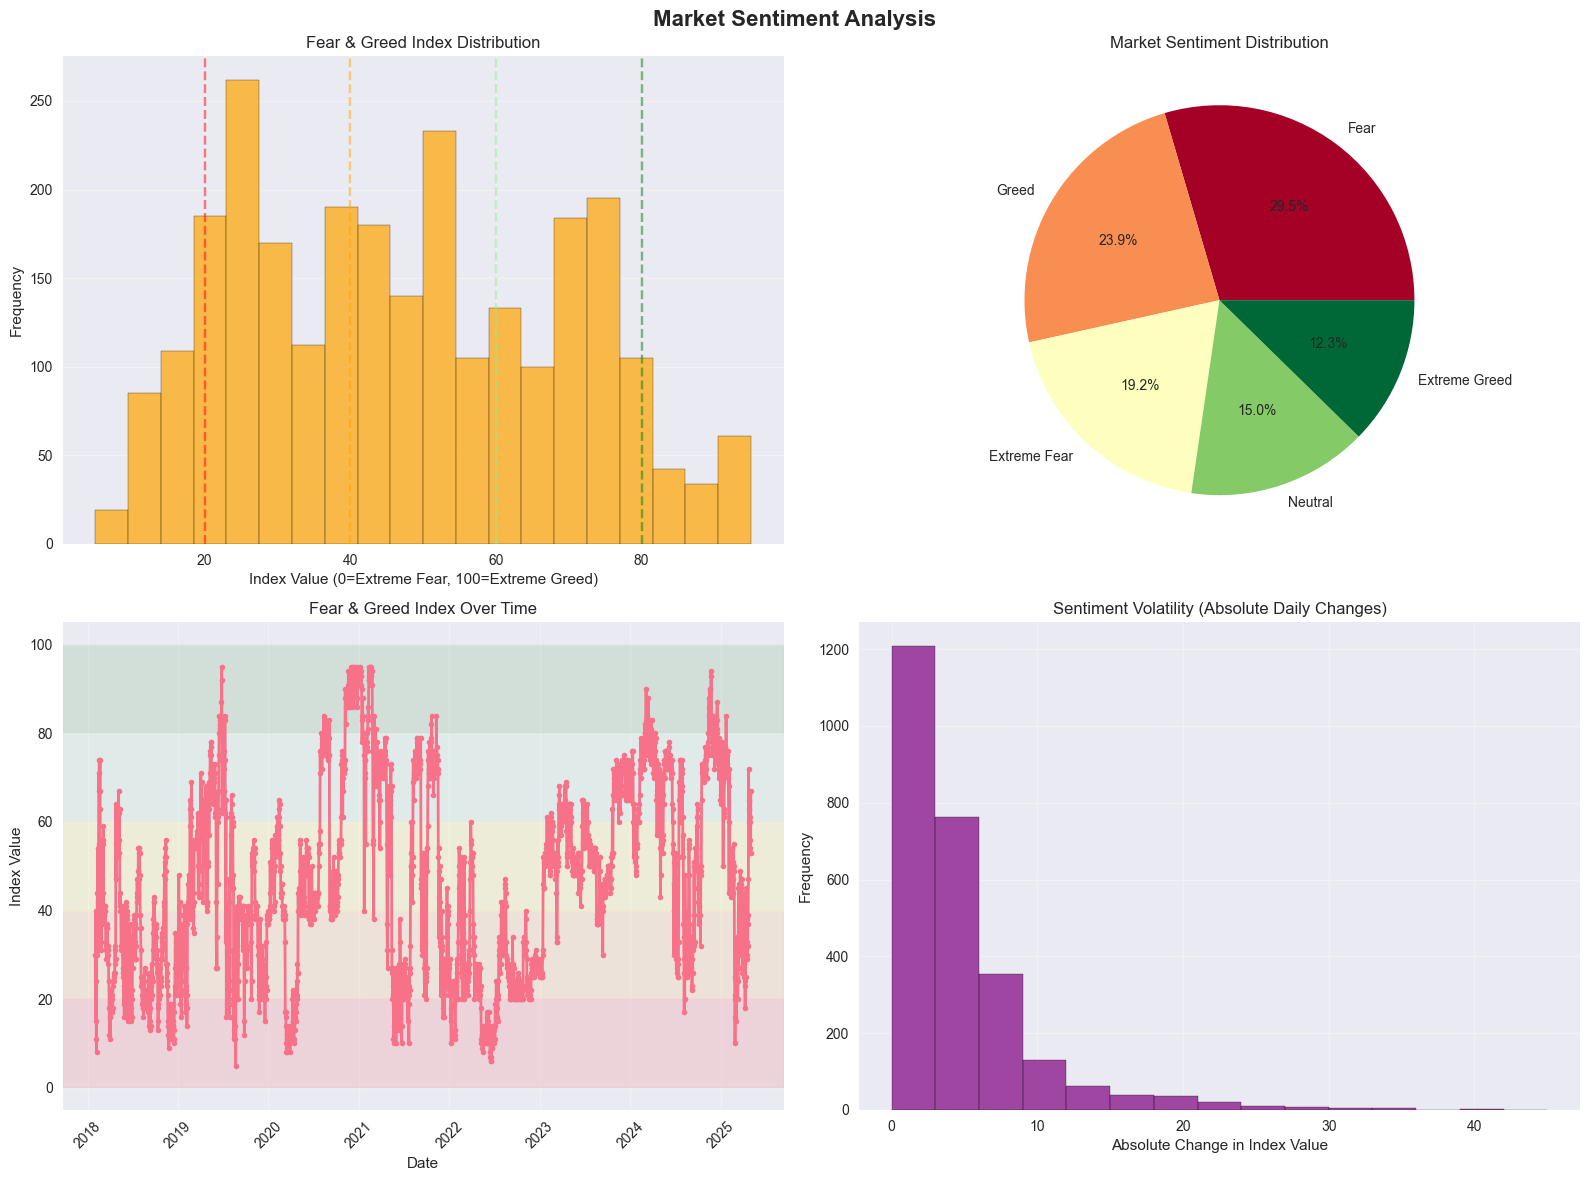

📊 Sentiment Statistics:
• Average Fear & Greed Index: 47.0
• Most volatile day: 45.0 point change
• Most common sentiment: Fear


In [26]:
print("📊 Market Sentiment Pattern Analysis")

# Create sentiment analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Market Sentiment Analysis', fontsize=16, fontweight='bold')

# 1. Fear & Greed Index Distribution
axes[0,0].hist(fear_greed_data['value'], bins=20, alpha=0.7, 
               color='orange', edgecolor='black')
axes[0,0].set_title('Fear & Greed Index Distribution')
axes[0,0].set_xlabel('Index Value (0=Extreme Fear, 100=Extreme Greed)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Add threshold lines
for threshold, label, color in [(20, 'Extreme Fear', 'red'), 
                               (40, 'Fear', 'orange'),
                               (60, 'Greed', 'lightgreen'),
                               (80, 'Extreme Greed', 'green')]:
    axes[0,0].axvline(threshold, color=color, alpha=0.5, linestyle='--')

# 2. Sentiment Classification Distribution
sentiment_counts = fear_greed_data['classification'].value_counts()
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(sentiment_counts)))
wedges, texts, autotexts = axes[0,1].pie(sentiment_counts.values, 
                                        labels=sentiment_counts.index, 
                                        autopct='%1.1f%%', colors=colors)
axes[0,1].set_title('Market Sentiment Distribution')

# 3. Sentiment Over Time
sentiment_daily = fear_greed_data.groupby('Date')['value'].mean().reset_index()
sentiment_daily['Date'] = pd.to_datetime(sentiment_daily['Date'])

axes[1,0].plot(sentiment_daily['Date'], sentiment_daily['value'], 
               marker='o', linewidth=2, markersize=4)
axes[1,0].set_title('Fear & Greed Index Over Time')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Index Value')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].tick_params(axis='x', rotation=45)

# Add colored background zones
axes[1,0].axhspan(0, 20, alpha=0.1, color='red', label='Extreme Fear')
axes[1,0].axhspan(20, 40, alpha=0.1, color='orange', label='Fear')
axes[1,0].axhspan(40, 60, alpha=0.1, color='yellow', label='Neutral')
axes[1,0].axhspan(60, 80, alpha=0.1, color='lightgreen', label='Greed')
axes[1,0].axhspan(80, 100, alpha=0.1, color='green', label='Extreme Greed')

# 4. Sentiment Volatility
fear_greed_data['value_change'] = fear_greed_data['value'].diff().abs()
axes[1,1].hist(fear_greed_data['value_change'].dropna(), bins=15, 
               alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_title('Sentiment Volatility (Absolute Daily Changes)')
axes[1,1].set_xlabel('Absolute Change in Index Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print sentiment statistics
print(f"📊 Sentiment Statistics:")
print(f"• Average Fear & Greed Index: {fear_greed_data['value'].mean():.1f}")
print(f"• Most volatile day: {fear_greed_data['value_change'].max():.1f} point change")
print(f"• Most common sentiment: {fear_greed_data['classification'].mode().iloc[0]}")


In [27]:
print("🔗 Merging Trading Data with Sentiment Data")

# Aggregate historical data by date
historical_daily = historical_data.groupby('Date').agg({
    'Closed PnL': ['sum', 'mean', 'count', 'std'],
    'Trade_Value_USD': ['sum', 'mean', 'count'],
    'PnL_Percentage': 'mean',
    'Is_Winning_Trade': 'mean',
    'Execution Price': 'mean'
}).round(4)

# Flatten column names
historical_daily.columns = ['_'.join(col).strip() for col in historical_daily.columns]
historical_daily = historical_daily.reset_index()

# Rename columns for clarity
column_mapping = {
    'Closed PnL_sum': 'Daily_Total_PnL',
    'Closed PnL_mean': 'Daily_Avg_PnL',
    'Closed PnL_count': 'Daily_Trade_Count',
    'Closed PnL_std': 'Daily_PnL_Volatility',
    'Trade_Value_USD_sum': 'Daily_Volume',
    'Trade_Value_USD_mean': 'Daily_Avg_Trade_Size',
    'Trade_Value_USD_count': 'Daily_Orders',
    'PnL_Percentage_mean': 'Daily_Return_Pct',
    'Is_Winning_Trade_mean': 'Daily_Win_Rate',
    'Execution Price_mean': 'Daily_Avg_Price'
}

historical_daily = historical_daily.rename(columns=column_mapping)

# Aggregate sentiment data by date (in case multiple readings per day)
sentiment_daily = fear_greed_data.groupby('Date').agg({
    'value': 'mean',
    'classification': lambda x: x.mode().iloc[0],
    'sentiment_score': 'mean'
}).round(2).reset_index()

# Merge datasets
merged_data = pd.merge(historical_daily, sentiment_daily, on='Date', how='inner')

print(f"✅ Successfully merged data:")
print(f"• Historical daily records: {len(historical_daily)}")
print(f"• Sentiment daily records: {len(sentiment_daily)}")
print(f"• Merged records: {len(merged_data)}")
print(f"• Date overlap: {len(merged_data)} days")

if len(merged_data) > 0:
    print(f"• Date range: {merged_data['Date'].min()} to {merged_data['Date'].max()}")
    print("\n📋 Merged Data Sample:")
    print(merged_data[['Date', 'Daily_Total_PnL', 'Daily_Win_Rate', 'value', 'classification']].head())
else:
    print("⚠️ No overlapping dates found between datasets")


🔗 Merging Trading Data with Sentiment Data
✅ Successfully merged data:
• Historical daily records: 480
• Sentiment daily records: 2644
• Merged records: 479
• Date overlap: 479 days
• Date range: 2023-05-01 to 2025-05-01

📋 Merged Data Sample:
         Date  Daily_Total_PnL  Daily_Win_Rate  value classification
0  2023-05-01           0.0000          0.0000   63.0          Greed
1  2023-12-05           0.0000          0.0000   75.0  Extreme Greed
2  2023-12-14        -205.4347          0.3636   72.0          Greed
3  2023-12-15         -24.6320          0.0000   70.0          Greed
4  2023-12-16           0.0000          0.0000   67.0          Greed


📈 Statistical Correlation Analysis
📊 Analyzing correlations between:
• Performance metrics: ['Daily_Total_PnL', 'Daily_Avg_PnL', 'Daily_Return_Pct', 'Daily_Win_Rate', 'Daily_Volume']
• Sentiment metrics: ['value', 'sentiment_score']


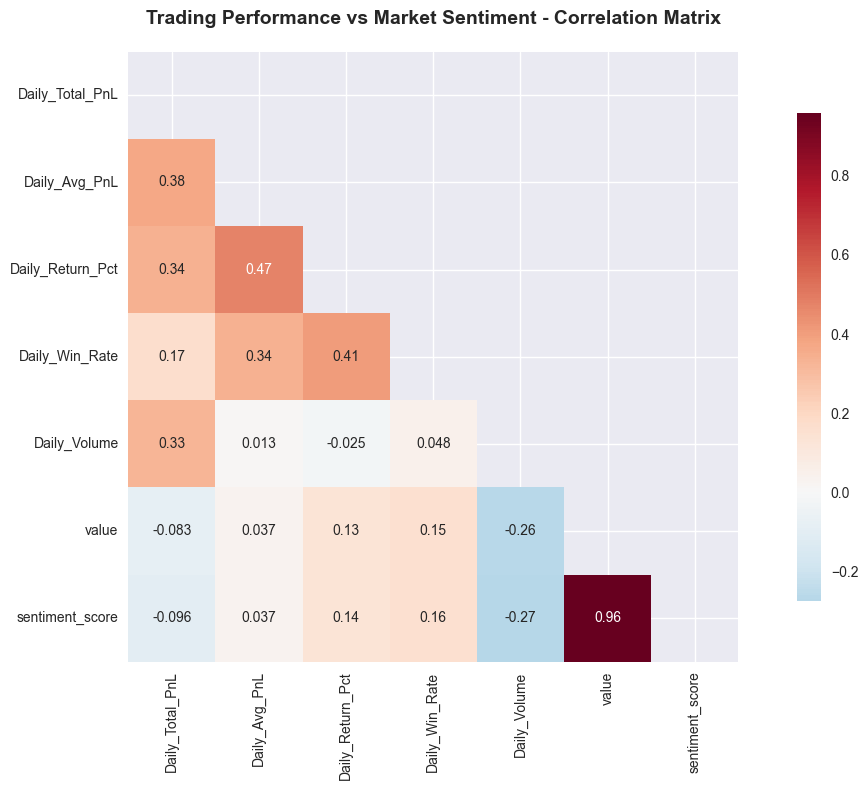


🔍 Detailed Correlation Results:
------------------------------------------------------------
Daily_Total_PnL vs value:
  Pearson: -0.083 (p=0.071) - Weak Negative
  Spearman: 0.040 (p=0.384) - Not Significant

Daily_Total_PnL vs sentiment_score:
  Pearson: -0.096 (p=0.035) - Weak Negative
  Spearman: 0.023 (p=0.618) - Significant

Daily_Avg_PnL vs value:
  Pearson: 0.037 (p=0.415) - Weak Positive
  Spearman: 0.100 (p=0.029) - Not Significant

Daily_Avg_PnL vs sentiment_score:
  Pearson: 0.037 (p=0.416) - Weak Positive
  Spearman: 0.082 (p=0.074) - Not Significant

Daily_Return_Pct vs value:
  Pearson: 0.132 (p=0.004) - Weak Positive
  Spearman: 0.192 (p=0.000) - Significant

Daily_Return_Pct vs sentiment_score:
  Pearson: 0.135 (p=0.003) - Weak Positive
  Spearman: 0.156 (p=0.001) - Significant

Daily_Win_Rate vs value:
  Pearson: 0.152 (p=0.001) - Weak Positive
  Spearman: 0.190 (p=0.000) - Significant

Daily_Win_Rate vs sentiment_score:
  Pearson: 0.156 (p=0.001) - Weak Positive
  S

In [28]:
print("📈 Statistical Correlation Analysis")
print("=" * 50)

if len(merged_data) == 0:
    print("❌ Cannot perform correlation analysis - no merged data available")
else:
    # Define performance and sentiment metrics
    performance_metrics = [
        'Daily_Total_PnL', 'Daily_Avg_PnL', 'Daily_Return_Pct', 
        'Daily_Win_Rate', 'Daily_Volume'
    ]
    
    sentiment_metrics = ['value', 'sentiment_score']
    
    # Filter available columns
    available_perf = [col for col in performance_metrics if col in merged_data.columns]
    available_sent = [col for col in sentiment_metrics if col in merged_data.columns]
    
    print(f"📊 Analyzing correlations between:")
    print(f"• Performance metrics: {available_perf}")
    print(f"• Sentiment metrics: {available_sent}")
    
    # Calculate correlation matrix
    correlation_data = merged_data[available_perf + available_sent].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    mask = np.triu(np.ones_like(correlation_data, dtype=bool))
    
    sns.heatmap(correlation_data, annot=True, cmap='RdBu_r', center=0,
                square=True, mask=mask, cbar_kws={"shrink": .8})
    plt.title('Trading Performance vs Market Sentiment - Correlation Matrix', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Detailed correlation analysis
    correlations = {}
    print(f"\n🔍 Detailed Correlation Results:")
    print("-" * 60)
    
    for perf_metric in available_perf:
        for sent_metric in available_sent:
            if perf_metric in merged_data.columns and sent_metric in merged_data.columns:
                # Remove NaN values for correlation calculation
                clean_data = merged_data[[perf_metric, sent_metric]].dropna()
                
                if len(clean_data) > 3:  # Need at least 4 points for meaningful correlation
                    pearson_corr, pearson_p = pearsonr(clean_data[perf_metric], 
                                                      clean_data[sent_metric])
                    spearman_corr, spearman_p = spearmanr(clean_data[perf_metric], 
                                                         clean_data[sent_metric])
                    
                    correlations[f"{perf_metric}_vs_{sent_metric}"] = {
                        'pearson': pearson_corr,
                        'pearson_p': pearson_p,
                        'spearman': spearman_corr,
                        'spearman_p': spearman_p
                    }
                    
                    # Interpret correlation strength
                    strength = ("Strong" if abs(pearson_corr) > 0.7 else 
                              "Moderate" if abs(pearson_corr) > 0.4 else "Weak")
                    direction = "Positive" if pearson_corr > 0 else "Negative"
                    significance = "Significant" if pearson_p < 0.05 else "Not Significant"
                    
                    print(f"{perf_metric} vs {sent_metric}:")
                    print(f"  Pearson: {pearson_corr:.3f} (p={pearson_p:.3f}) - {strength} {direction}")
                    print(f"  Spearman: {spearman_corr:.3f} (p={spearman_p:.3f}) - {significance}")
                    print()


📊 Sentiment vs Performance Visualizations


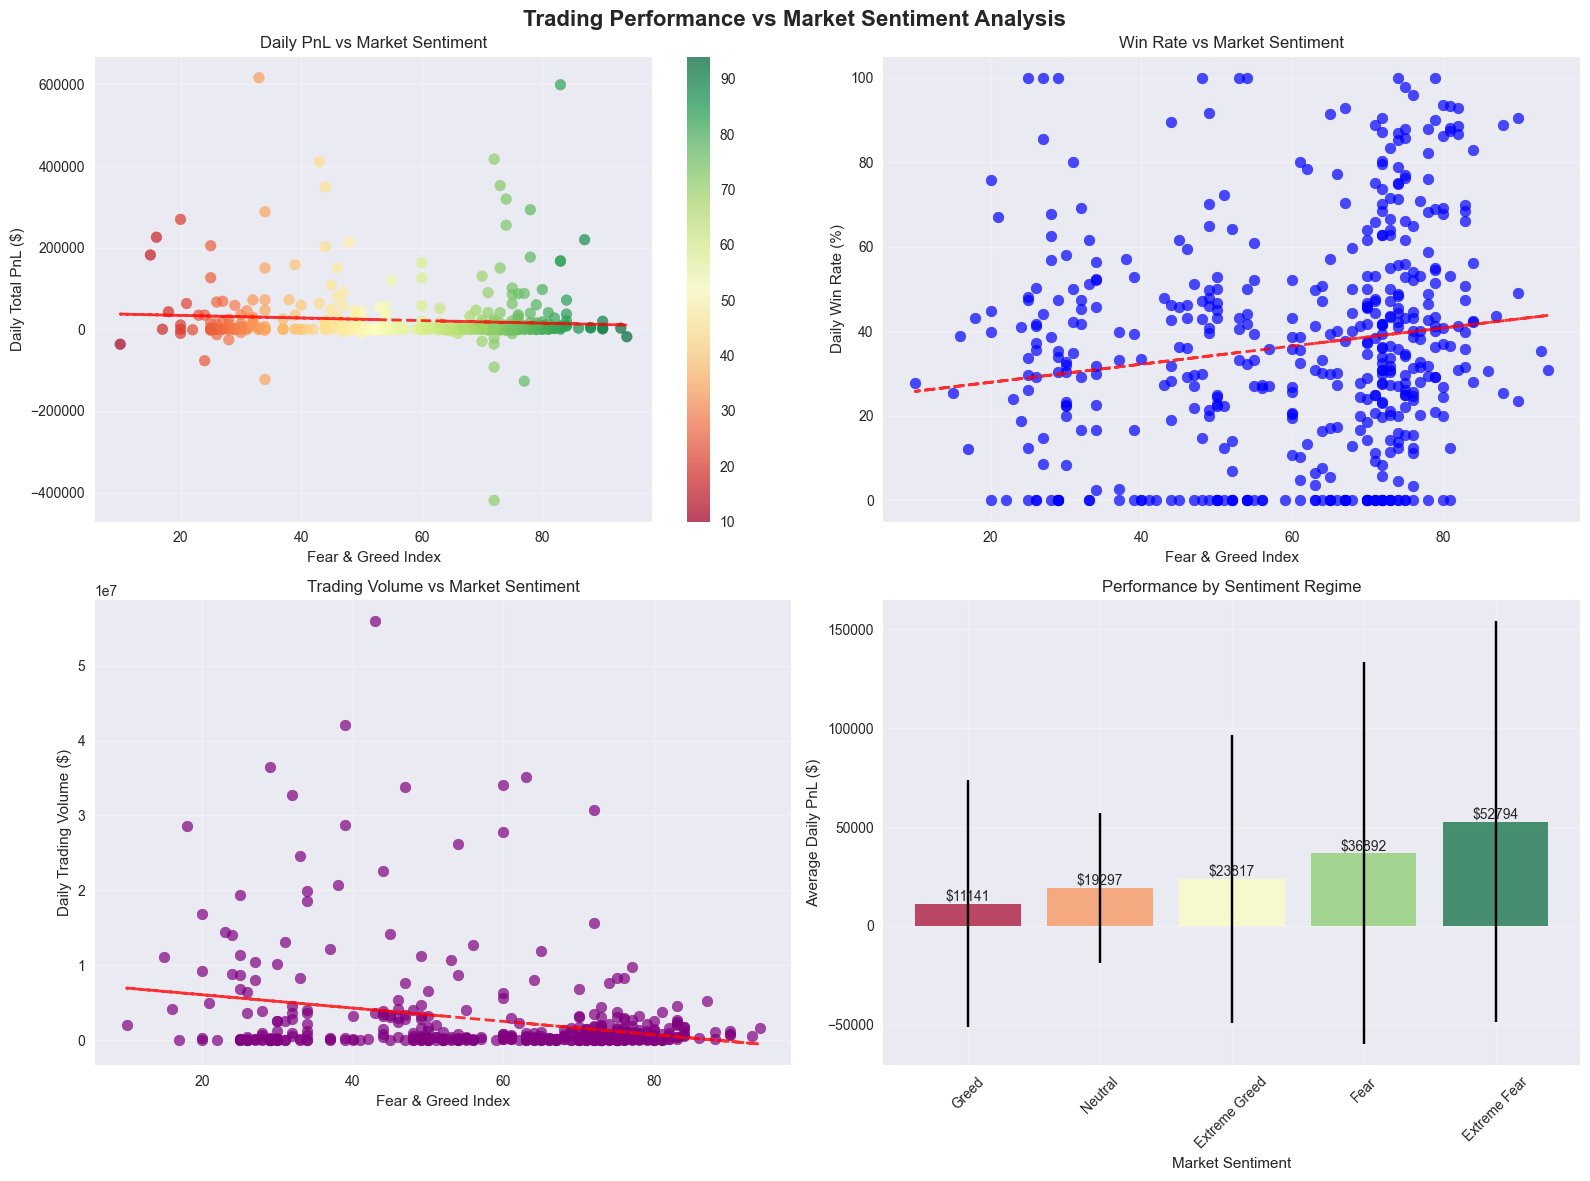

📊 Performance by Sentiment Summary:
--------------------------------------------------
Greed          : $11140.57 ± $62427.96 (193 days)
Neutral        : $19297.32 ± $37995.21 (67 days)
Extreme Greed  : $23817.29 ± $72827.30 (114 days)
Fear           : $36891.82 ± $96611.85 (91 days)
Extreme Fear   : $52793.59 ± $101262.39 (14 days)


In [29]:
print("📊 Sentiment vs Performance Visualizations")

if len(merged_data) > 0:
    # Create comprehensive sentiment-performance plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Trading Performance vs Market Sentiment Analysis', 
                 fontsize=16, fontweight='bold')
    
    # 1. Total Daily PnL vs Fear & Greed Index
    if 'Daily_Total_PnL' in merged_data.columns:
        scatter = axes[0,0].scatter(merged_data['value'], merged_data['Daily_Total_PnL'], 
                                   c=merged_data['value'], cmap='RdYlGn', 
                                   alpha=0.7, s=60)
        
        # Add regression line
        z = np.polyfit(merged_data['value'], merged_data['Daily_Total_PnL'], 1)
        p = np.poly1d(z)
        axes[0,0].plot(merged_data['value'], p(merged_data['value']), 
                       "r--", alpha=0.8, linewidth=2)
        
        axes[0,0].set_xlabel('Fear & Greed Index')
        axes[0,0].set_ylabel('Daily Total PnL ($)')
        axes[0,0].set_title('Daily PnL vs Market Sentiment')
        axes[0,0].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[0,0])
    
    # 2. Win Rate vs Sentiment
    if 'Daily_Win_Rate' in merged_data.columns:
        axes[0,1].scatter(merged_data['value'], merged_data['Daily_Win_Rate']*100, 
                         alpha=0.7, color='blue', s=60)
        
        # Add regression line
        z = np.polyfit(merged_data['value'], merged_data['Daily_Win_Rate']*100, 1)
        p = np.poly1d(z)
        axes[0,1].plot(merged_data['value'], p(merged_data['value']), 
                       "r--", alpha=0.8, linewidth=2)
        
        axes[0,1].set_xlabel('Fear & Greed Index')
        axes[0,1].set_ylabel('Daily Win Rate (%)')
        axes[0,1].set_title('Win Rate vs Market Sentiment')
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Trading Volume vs Sentiment
    if 'Daily_Volume' in merged_data.columns:
        axes[1,0].scatter(merged_data['value'], merged_data['Daily_Volume'], 
                         alpha=0.7, color='purple', s=60)
        
        # Add regression line
        z = np.polyfit(merged_data['value'], merged_data['Daily_Volume'], 1)
        p = np.poly1d(z)
        axes[1,0].plot(merged_data['value'], p(merged_data['value']), 
                       "r--", alpha=0.8, linewidth=2)
        
        axes[1,0].set_xlabel('Fear & Greed Index')
        axes[1,0].set_ylabel('Daily Trading Volume ($)')
        axes[1,0].set_title('Trading Volume vs Market Sentiment')
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Performance by Sentiment Classification
    if 'classification' in merged_data.columns and 'Daily_Total_PnL' in merged_data.columns:
        sentiment_performance = merged_data.groupby('classification').agg({
            'Daily_Total_PnL': ['mean', 'std', 'count']
        }).round(2)
        
        sentiment_performance.columns = ['Mean_PnL', 'Std_PnL', 'Count']
        sentiment_performance = sentiment_performance.reset_index()
        
        # Sort by performance
        sentiment_performance = sentiment_performance.sort_values('Mean_PnL')
        
        bars = axes[1,1].bar(range(len(sentiment_performance)), 
                            sentiment_performance['Mean_PnL'],
                            yerr=sentiment_performance['Std_PnL'],
                            capsize=5, alpha=0.7,
                            color=plt.cm.RdYlGn(np.linspace(0, 1, len(sentiment_performance))))
        
        axes[1,1].set_xlabel('Market Sentiment')
        axes[1,1].set_ylabel('Average Daily PnL ($)')
        axes[1,1].set_title('Performance by Sentiment Regime')
        axes[1,1].set_xticks(range(len(sentiment_performance)))
        axes[1,1].set_xticklabels(sentiment_performance['classification'], rotation=45)
        axes[1,1].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, value) in enumerate(zip(bars, sentiment_performance['Mean_PnL'])):
            height = bar.get_height()
            axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                          f'${value:.0f}', ha='center', 
                          va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    if 'classification' in merged_data.columns and 'Daily_Total_PnL' in merged_data.columns:
        print("📊 Performance by Sentiment Summary:")
        print("-" * 50)
        for _, row in sentiment_performance.iterrows():
            print(f"{row['classification']:15}: ${row['Mean_PnL']:7.2f} ± ${row['Std_PnL']:6.2f} ({row['Count']} days)")

In [35]:
historical_data['Timestamp IST'] = pd.to_datetime(historical_data['Timestamp IST'])
historical_data['date'] = historical_data['Timestamp IST'].dt.date
historical_data['hour'] = historical_data['Timestamp IST'].dt.hour
historical_data['day_of_week'] = historical_data['Timestamp IST'].dt.dayofweek

# Prepare fear & greed data
fear_greed_data['date'] = pd.to_datetime(fear_greed_data['date']).dt.date

# Merge datasets on date
merged_data = historical_data.merge(fear_greed_data, on='date', how='left')
merged_data['fear_greed_value'] = merged_data['value'].fillna(merged_data['value'].median())

print("✅ Data preprocessing completed")
print(f"Merged dataset shape: {merged_data.shape}")
print(f"Date range: {merged_data['date'].min()} to {merged_data['date'].max()}")

# Create comprehensive trader behavior features
def create_clustering_features(df):
    """
    Create advanced features for trader clustering analysis using actual data structure
    """
    # Group by Account (trader) to create features
    trader_features = df.groupby('Account').agg({
        'Size USD': ['sum', 'mean', 'std', 'count'],  # Trading volume metrics
        'Closed PnL': ['sum', 'mean', 'std'],         # Profit/Loss metrics  
        'Fee': ['sum', 'mean'],                       # Fee analysis
        'Coin': lambda x: x.nunique(),                # Asset diversification
        'hour': lambda x: x.mode().iloc[0] if not x.empty else 12,  # Preferred trading hour
        'fear_greed_value': ['mean', 'std'],          # Market sentiment exposure
    }).round(4)
    
    # Flatten column names
    trader_features.columns = ['_'.join(col).strip() for col in trader_features.columns]
    
    # Add derived behavioral features
    trader_features['win_rate'] = df.groupby('Account')['Closed PnL'].apply(lambda x: (x > 0).mean())
    trader_features['profit_per_trade'] = trader_features['Closed PnL_sum'] / trader_features['Size USD_count']
    trader_features['fee_efficiency'] = trader_features['Closed PnL_sum'] / (trader_features['Fee_sum'] + 1e-8)
    trader_features['volume_consistency'] = 1 / (1 + trader_features['Size USD_std'] / (trader_features['Size USD_mean'] + 1e-8))
    trader_features['activity_level'] = trader_features['Size USD_count']
    trader_features['asset_diversity'] = trader_features['Coin_<lambda>']
    
    # Risk and performance metrics
    trader_features['sharpe_ratio'] = trader_features['Closed PnL_mean'] / (trader_features['Closed PnL_std'] + 1e-8)
    trader_features['profit_factor'] = trader_features['Closed PnL_sum'] / (abs(trader_features['Closed PnL_sum'].clip(upper=0)) + 1e-8)
    trader_features['sentiment_sensitivity'] = trader_features['fear_greed_value_std']
    
    return trader_features.fillna(0)

# Apply feature engineering
clustering_features = create_clustering_features(merged_data)
print(f"✅ Created {clustering_features.shape[1]} features for {clustering_features.shape[0]} traders")
print("\nTop traders by total volume:")
print(clustering_features.nlargest(5, 'Size USD_sum')[['Size USD_sum', 'Closed PnL_sum', 'win_rate']].round(2))


✅ Data preprocessing completed
Merged dataset shape: (211224, 34)
Date range: 2023-05-01 to 2025-05-01
✅ Created 22 features for 32 traders

Top traders by total volume:
                                            Size USD_sum  Closed PnL_sum  \
Account                                                                    
0x513b8629fe877bb581bf244e326a047b249c4ff1  4.208766e+08       840422.56   
0x4f93fead39b70a1824f981a54d4e55b278e9f760  1.296725e+08       308975.87   
0xb899e522b5715391ae1d4f137653e7906c5e2115  1.088770e+08        22488.50   
0xbee1707d6b44d4d52bfe19e41f8a828645437aab  7.410781e+07       836080.55   
0xbaaaf6571ab7d571043ff1e313a9609a10637864  6.803634e+07       940163.81   

                                            win_rate  
Account                                               
0x513b8629fe877bb581bf244e326a047b249c4ff1      0.40  
0x4f93fead39b70a1824f981a54d4e55b278e9f760      0.36  
0xb899e522b5715391ae1d4f137653e7906c5e2115      0.44  
0xbee1707d6b44d4d52bfe

In [36]:
selected_features = [
    'Size USD_sum',           # Total trading volume
    'Size USD_mean',          # Average trade size
    'Closed PnL_sum',         # Total profit/loss
    'Closed PnL_mean',        # Average profit per trade
    'win_rate',               # Win rate percentage
    'profit_per_trade',       # Profitability efficiency
    'fee_efficiency',         # Cost efficiency
    'activity_level',         # Trading frequency
    'asset_diversity',        # Number of different coins traded
    'sharpe_ratio',           # Risk-adjusted returns
    'sentiment_sensitivity'   # Reaction to market sentiment
]

# Prepare data for clustering
X_cluster = clustering_features[selected_features].copy()

# Handle any remaining NaN or infinite values
X_cluster = X_cluster.replace([np.inf, -np.inf], np.nan).fillna(0)

# Remove any traders with zero activity
active_traders_mask = X_cluster['activity_level'] > 0
X_cluster = X_cluster[active_traders_mask]

print(f"✅ Filtered to {X_cluster.shape[0]} active traders")
print(f"Features selected: {len(selected_features)}")

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"✅ Feature scaling completed")
print(f"Scaled data range: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")


✅ Filtered to 32 active traders
Features selected: 11
✅ Feature scaling completed
Scaled data range: [-2.312, 5.058]


## Created By Jeevasurya Palanisamy - Junior Data Scientist